<a href="https://colab.research.google.com/github/dany98sa/FitDiary_FIA/blob/main/Classificazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione

## Ottenimento del dataset

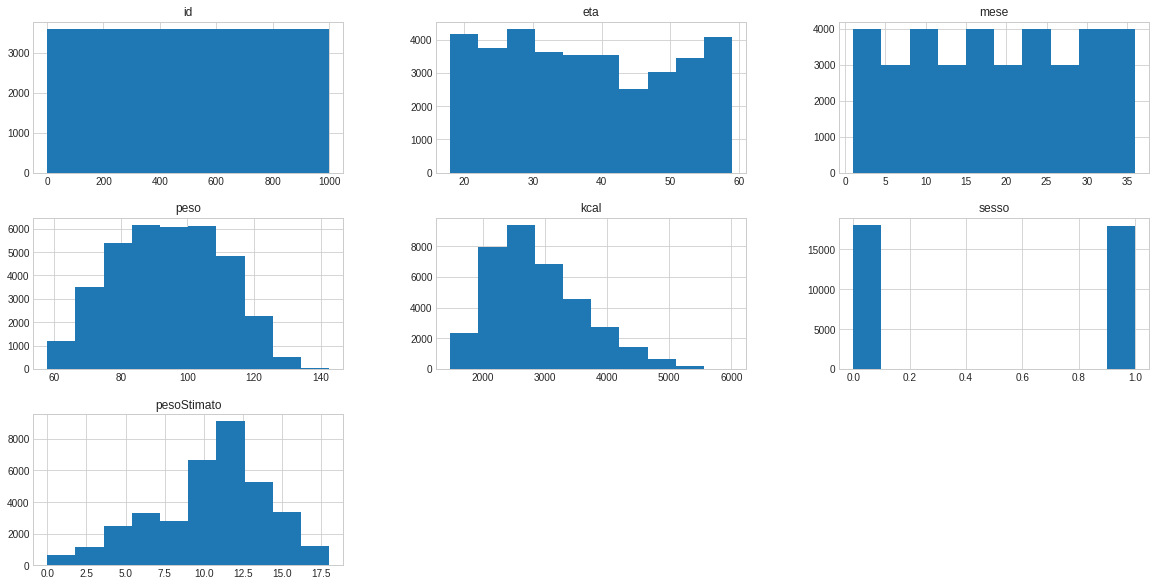

id  eta  mese       peso  kcal  sesso  pesoStimato
0   1   31     1   97.00000  1965      0            4
1   1   31     2   99.06005  2047      0            5
2   1   31     3  100.93987  2127      0            4
3   1   31     4  103.08139  2365      0            9
4   1   31     5  103.97695  2900      0           12

In [36]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from six.moves import urllib
from matplotlib import style

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/datasetClassificazione.csv"

def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df.head(5)
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1) DataCleaning

### 1.1) Descrizione del dataset

In [37]:
df.describe()

id          eta  ...         sesso   pesoStimato
count  36000.000  36000.00000  ...  36000.000000  36000.000000
mean     500.500     37.73400  ...      0.499000     10.286444
std      288.679     12.03899  ...      0.500006      3.722119
min        1.000     18.00000  ...      0.000000      0.000000
25%      250.750     28.00000  ...      0.000000      8.000000
50%      500.500     37.00000  ...      0.000000     11.000000
75%      750.250     48.00000  ...      1.000000     13.000000
max     1000.000     59.00000  ...      1.000000     18.000000

[8 rows x 7 columns]

### 1.2) Verifica valori null nel dataset

In [38]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

In [39]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Correlazione delle features

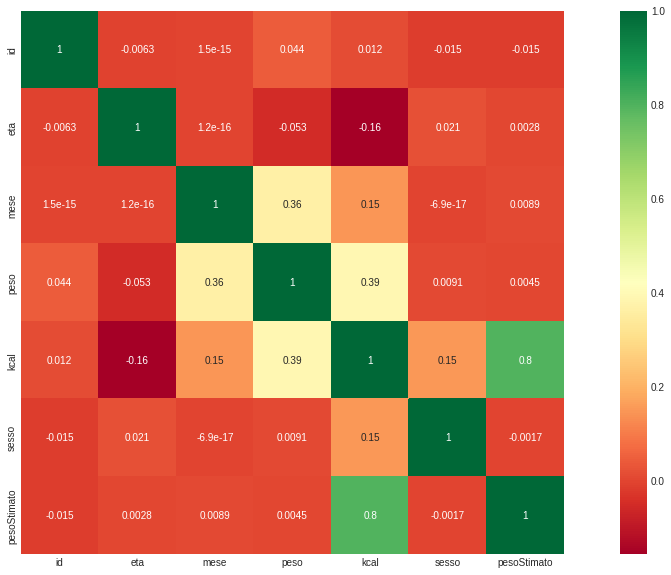

In [40]:
#dipendenze tra variabili
import seaborn as sb
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) definizione classe Metrics1

In [41]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,precision,recall,accuracy,mcc):
    self.precision=precision
    self.recall=recall
    self.accuracy=accuracy
    self.mcc=mcc
  
  #ToString
  def __str__(self):
    return f'Metrics [precision= {self.precision} recall= {self.recall} accuracy= {self.accuracy} mcc= {self.mcc}'

### 2.2) Definizione class MetricsResultContainer

In [42]:
import numpy as np
class MetricsResultContainer:
  meanPrecision = []
  meanRecall = []
  meanAccuracy = []
  meanMcc =[]
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean,balance):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanPrecision = []
    self.meanRecall = []
    self.meanAccuracy = []
    self.meanMcc =[]
    self.balance=balance
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanPrecision.append(m.precision)
      self.meanRecall.append(m.recall)
      self.meanAccuracy.append(m.accuracy)
      self.meanMcc.append(m.mcc)
    print("meanPrecision=",np.mean(self.meanPrecision))    
    print("meanRecall=",np.mean(self.meanRecall))    
    print("meanAccuracy=",np.mean(self.meanAccuracy))
    print("meanMcc=",np.mean(self.meanMcc))

### 2.3) Definizione funzione generateModel

In [50]:
import copy
from sklearn import metrics, clone
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

def generateModel(alg, scaler, model, select,balance):
  #array di metriche (precision, recall, accuracy, mcc)
  metrics1 = []
  #generazione n_split test/trainig sets
  
  for train_index, test_index in alg.split(X,y):
    clone_model = clone(model)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)

    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train)

    #validazione modello e applicazione predizione sui testSet
    y_pred = clone_model.predict(X_test_z)

    #calcolo metriche predizion
    cm=metrics.confusion_matrix(y_test,y_pred)
    TP, FP, TN, FN = perf_measure(cm)
    metrics1.append(Metrics1((TP/(TP+FP)),(TP/(TP+FN)),
                            ((TP+TN)/(TP+TN+FP+FN)),
                            metrics.matthews_corrcoef(y_test,y_pred)))
  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns='pesoStimato')
y=df.pesoStimato
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con k gruppi
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold(n_splits=2, n_repeats=8, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_classif, k=4)
#risultati: array di array di metriche
metricsResults = []

###2.4) Data Balancing

In [46]:
from imblearn.under_sampling import RandomUnderSampler

#funzione per bilanciare i dati uso di undersample
def bilanciamentoDatiUnderSampling(X_train,y_train):
  undersample = RandomUnderSampler(sampling_strategy='majority')
  X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
  return X_train_under, y_train_under

In [47]:
from imblearn.over_sampling import RandomOverSampler

#funzione per bilanciare i dati uso di overfitting
def bilanciamentoDatiOverSampling(X_train,y_train):
  oversample = RandomOverSampler(random_state=42)
  X_train_over, y_train_over= oversample.fit_resample(X_train, y_train)
  return X_train_over, y_train_over

In [48]:
def perf_measure(confusionMatrix):
  meanTP = []
  meanFP = []
  meanTN = []
  meanFN = []

  for i in range(len(confusionMatrix)):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for y in range(len(confusionMatrix)): 
      if i==y:
        TP += confusionMatrix[i][y]
      if i!=y:
        FP += confusionMatrix[y][i]
        FN += confusionMatrix[i][y]
    for j in range(len(confusionMatrix)):
      for x in range(len(confusionMatrix)):
        if j!=i and x!= i:
          TN += confusionMatrix[j][x]
    meanTP.append(TP)
    meanFP.append(FP)
    meanTN.append(TN)
    meanFN.append(FN)
  return(np.mean(meanTP), np.mean(meanFP), np.mean(meanTN), np.mean(meanFN))

## 3) Model testing

### 3.1) NaiveBayes

#### 3.1.1) Gaussian Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

print("Gaussian Naive Bayes - ZScore Normalization - KF-Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - ZScore Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - MinMax Normalization - KF- Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - MinMax Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - RobustScaler Normalization - KF- Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - RobustScaler Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), GaussianNB(), select,bilanciamentoDatiUnderSampling),"underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - ZScore Normalization - KF-Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - ZScore Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - MinMax Normalization - KF- Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - MinMax Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - RobustScaler Normalization - KF- Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nGaussian Naive Bayes - RobustScaler Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Gaussian Naive Bayes","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), GaussianNB(), select,bilanciamentoDatiOverSampling),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

Gaussian Naive Bayes - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.21461111111111109
meanRecall= 0.21461111111111109
meanAccuracy= 0.917327485380117
meanMcc= 0.13523482985130067

Gaussian Naive Bayes - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.21458888888888888
meanRecall= 0.21458888888888888
meanAccuracy= 0.9173251461988304
meanMcc= 0.135107749496036

Gaussian Naive Bayes - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.21461111111111109
meanRecall= 0.21461111111111109
meanAccuracy= 0.917327485380117
meanMcc= 0.13523482985130067

Gaussian Naive Bayes - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.21458888888888888
meanRecall= 0.21458888888888888
meanAccuracy= 0.9173251461988304
meanMcc= 0.135107749496036

Gaussian Naive Bayes - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.21461111111111109
meanRecall= 0.21461111111111109
meanAccuracy= 0.917327485380117
meanMcc= 0.13523482985130067

Gaussian Naive Bayes - RobustS

### 3.1.2 Bernoulli Naive Bayes

In [52]:
from sklearn.naive_bayes import BernoulliNB

print("Bernoulli Naive Bayes - ZScore Normalization - KF-Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - ZScore Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - MinMax Normalization - KF- Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - MinMax Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - RobustScaler Normalization - KF- Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - RobustScaler Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), BernoulliNB(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - ZScore Normalization - KF-Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - ZScore Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - MinMax Normalization - KF- Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - MinMax Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - RobustScaler Normalization - KF- Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nBernoulli Naive Bayes - RobustScaler Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Bernoulli Naive Bayes","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), BernoulliNB(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

Bernoulli Naive Bayes - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.14819444444444446
meanRecall= 0.14819444444444446
meanAccuracy= 0.9103362573099416
meanMcc= 0.0475090832187708

Bernoulli Naive Bayes - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.14681666666666668
meanRecall= 0.14681666666666668
meanAccuracy= 0.9101912280701756
meanMcc= 0.045635282331323156

Bernoulli Naive Bayes - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.12458333333333334
meanRecall= 0.12458333333333334
meanAccuracy= 0.9078508771929824
meanMcc= 0.00016375768748426195

Bernoulli Naive Bayes - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.12589166666666668
meanRecall= 0.12589166666666668
meanAccuracy= 0.9079885964912281
meanMcc= -0.000963168674251518

Bernoulli Naive Bayes - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.16175
meanRecall= 0.16175
meanAccuracy= 0.9117631578947369
meanMcc= 0.07707294592492162

Bernoulli Naive Bayes - RobustScaler 

## 3.2 Decision tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

print("Decision Tree Classifier - ZScore Normalization - KF-Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - ZScore Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - MinMax Normalization - KF- Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - MinMax Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - RobustScaler Normalization - KF- Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - RobustScaler Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - ZScore Normalization - KF-Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - ZScore Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - MinMax Normalization - KF- Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - MinMax Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - RobustScaler Normalization - KF- Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nDecision Tree Classifier - RobustScaler Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Decision Tree Classifier","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

Decision Tree Classifier - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.2762777777777778
meanRecall= 0.2762777777777778
meanAccuracy= 0.9238187134502923
meanMcc= 0.21450519171088028

Decision Tree Classifier - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.2663027777777778
meanRecall= 0.2663027777777778
meanAccuracy= 0.9227687134502925
meanMcc= 0.20380304282343645

Decision Tree Classifier - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.27547222222222223
meanRecall= 0.27547222222222223
meanAccuracy= 0.9237339181286548
meanMcc= 0.21364636442355422

Decision Tree Classifier - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.266575
meanRecall= 0.266575
meanAccuracy= 0.9227973684210525
meanMcc= 0.2040960398606181

Decision Tree Classifier - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.27644444444444444
meanRecall= 0.27644444444444444
meanAccuracy= 0.9238362573099417
meanMcc= 0.2147854874693623

Decision Tree Classifier - Robu

## 3.3) VotingClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

voting=VotingClassifier(estimators=[('dt',DecisionTreeClassifier(max_depth=4)),
                                    ('knn',KNeighborsClassifier(n_neighbors=7)),
                                    ('scv',SVC(kernel="rbf",probability=True))],
                        voting="hard")

print("Voting Classifier - ZScore Normalization - KF-Under Sampler")
m = MetricsResultContainer("Voting Classifier","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - ZScore Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - MinMax Normalization - KF- Under Sampler")
m = MetricsResultContainer("Voting Classifier","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - MinMax Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - RobustScaler Normalization - KF- Under Sampler")
m = MetricsResultContainer("Voting Classifier","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - RobustScaler Normalization - RKF- Under Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), voting, select,bilanciamentoDatiUnderSampling), "underSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - ZScore Normalization - KF-Over Sampler")
m = MetricsResultContainer("Voting Classifier","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - ZScore Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - MinMax Normalization - KF- Over Sampler")
m = MetricsResultContainer("Voting Classifier","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - MinMax Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - RobustScaler Normalization - KF- Over Sampler")
m = MetricsResultContainer("Voting Classifier","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()

print("\nVoting Classifier - RobustScaler Normalization - RKF- Over Sampler")
m = MetricsResultContainer("Voting Classifier","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), voting, select,bilanciamentoDatiOverSampling), "overSampler"
)
metricsResults.append(m)
m.printMetrics()


Voting Classifier - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.28411111111111115
meanRecall= 0.28411111111111115
meanAccuracy= 0.9246432748538012
meanMcc= 0.21622401558444643

Voting Classifier - ZScore Normalization - RKF- Under Sampler
